# Question 1: Decision Tree
---
Samarth Kumar

In [ ]:
import numpy as np
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

Load the data from UCI ML Repository

In [ ]:
%pip install ucimlrepo #This command is required when loading data directly with code.

In [ ]:
from ucimlrepo import fetch_ucirepo
wine_quality = fetch_ucirepo(id=186)
X = wine_quality.data.features
y = wine_quality.data.targets

In [ ]:
X.shape, y.shape

((6497, 11), (6497, 1))

In [ ]:
display(X.head())

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4


In [ ]:
display(y.head())

,quality
0,5
1,5
2,5
3,6
4,5


In [ ]:
# Convert to NumPy
xFeat = X.to_numpy()
y = y.to_numpy()

# Convert quality scores into binary classification.
# Good quality (1) if >= 6 otherwise Bad (0)
y = np.where(y >= 6, 1, 0).reshape(-1, 1)

In [ ]:
# Split into training (70%) and test (30%)
indices = np.random.permutation(len(xFeat))
splitIndex = int(0.7 * len(xFeat))
trainIndex, testIndex = indices[:splitIndex], indices[splitIndex:]
xTrain, yTrain = xFeat[trainIndex], y[trainIndex]
xTest, yTest = xFeat[testIndex], y[testIndex]

Now the data is ready for model training.

## Decision Tree
---

Define a node structure for storing predictions and building the tree.

In [ ]:
class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, gain=None, prediction=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.gain = gain
        self.prediction = prediction

Define the class for the Decision Tree model. Including the following parts of Question 1:
* a) Implement the train function.
* b) Implement the predict function.

In [ ]:
class DecisionTreeClassifier:
    def __init__(self, max_depth, min_samples):
        self.tree = None
        self.depth = 0
        self.max_depth = max_depth
        self.min_samples = min_samples

    '''
    Helper functions, primarily used by the train function.
    '''

    # Calculate Gini impurity.
    def gini_index(self, y):
        _ , counts = np.unique(y, return_counts=True)
        return 1 - np.sum((counts / counts.sum()) ** 2)

    # Find the best feature and threshold to split on.
    def split(self, xFeat, y):
        bestGain = 0
        bestFeature = None
        bestThreshold = None
        n_samples, n_features = xFeat.shape

        current = self.gini_index(y)

        for feature in range(n_features):
            # Use unique values as thresholds, for partitioning the data.
            thresholds = np.unique(xFeat[:, feature])

            for threshold in thresholds:
                # Values <= threshold go to left, otherwise to the right.
                leftIndex = xFeat[:, feature] <= threshold
                rightIndex = xFeat[:, feature] > threshold

                # Skip empty nodes.
                if leftIndex.sum() == 0 or rightIndex.sum() == 0:
                    continue

                # Calculate the weighted Gini.
                leftGini = self.gini_index(y[leftIndex])
                rightGini = self.gini_index(y[rightIndex])
                weighted = (leftIndex.sum() / n_samples) * leftGini + (rightIndex.sum() / n_samples) * rightGini

                # Calculate the information gain, difference between current and weighted Gini.
                gain = current - weighted

                # Update the best gain, feature, and threshold to determine the best split (highest gain).
                if gain > bestGain:
                    bestGain, bestFeature, bestThreshold = gain, feature, threshold

        return bestGain, bestFeature, bestThreshold

    '''
    (a) Define the train function.
    '''
    def train(self, xFeat, y):
        # Return the leaf if all labels are same.
        if len(np.unique(y)) == 1:
            return Node(prediction=y[0][0])

        # If stopping conditions are met (based on hyperparameters), return leaf node with the most common class.
        if self.depth >= self.max_depth or len(y) < self.min_samples:
            most_common_label = np.bincount(y.flatten()).argmax()
            return Node(prediction=most_common_label)

        # Find the best feature and threshold values for splitting.
        bestGain, bestFeature, bestThreshold = self.split(xFeat, y)

        # Return leaf if no split is made.
        if bestFeature is None:
            most_common_label = np.bincount(y.flatten()).argmax()
            return Node(prediction=most_common_label)

        # Split the data.
        leftIndex = xFeat[:, bestFeature] <= bestThreshold
        rightIndex = xFeat[:, bestFeature] > bestThreshold

        # Build the left and right subtrees.
        self.depth += 1
        leftTree = self.train(xFeat[leftIndex], y[leftIndex])
        rightTree = self.train(xFeat[rightIndex], y[rightIndex])

        # Return a node with the best feature, threshold, and subtrees.
        self.tree = Node(feature=bestFeature,
                         threshold=bestThreshold,
                         left=leftTree,
                         right=rightTree,
                         gain=bestGain)

        return self.tree


    '''
    (b) Define the predict function
    '''
    def predict(self, xTest):
        predictions = []

        for row in xTest:
            node = self.tree
            while node.prediction is None:
                if row[node.feature] <= node.threshold:
                    node = node.left
                else:
                    node = node.right
            predictions.append(node.prediction)

        return np.array(predictions).reshape(-1, 1)


Compute and store the accuracies for different hyperparameter values (maximum depth, minimum number of samples per leaf)

In [ ]:
# Test depths and minimum samples split to 20.
depths = np.arange(1, 21, 2)
samples = np.arange(2, 21, 2)

# Store accuracy results
trainResults = np.zeros((len(depths), len(samples)))
testResults = np.zeros((len(depths), len(samples)))

# Train models with different hyperparameters
for i, depth in enumerate(depths):
    for j, samp in enumerate(samples):
        # Train the Decision Tree Model
        treeModel = DecisionTreeClassifier(depth, samp)
        treeModel.train(xTrain, yTrain)

        # Predict on Train and Test Data
        yTrainPred = treeModel.predict(xTrain)
        yPred = treeModel.predict(xTest)

        # Store accuracies
        trainResults[i, j] = np.mean(yTrainPred == yTrain)
        testResults[i, j] = np.mean(yPred == yTest)

# Prepare data for 3D plots
xGrid, yGrid = np.meshgrid(depths, samples)
zTrain = trainResults.T
zTest = testResults.T


### Create 3D Plots
---
Question 1 part (c) : See how the hyperparameters affect accuracy, including the plots.

Train Accuracy

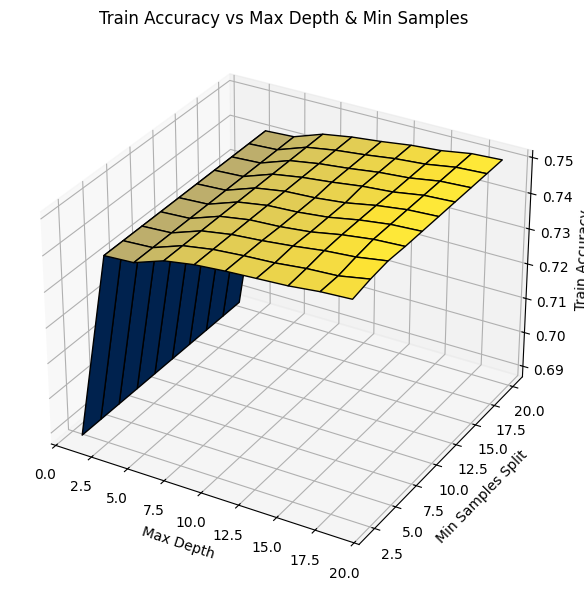

In [ ]:
fig1 = plt.figure(figsize=(6,6))
ax1 = fig1.add_subplot(111, projection='3d')
ax1.plot_surface(xGrid, yGrid, zTrain, cmap='cividis', edgecolor='black', antialiased=True, shade=True)
ax1.set_xlabel('Max Depth')
ax1.set_ylabel('Min Samples Split')
ax1.set_zlabel('Train Accuracy')
ax1.set_title('Train Accuracy vs Max Depth & Min Samples')
plt.tight_layout()
plt.show()

Test Accuracy

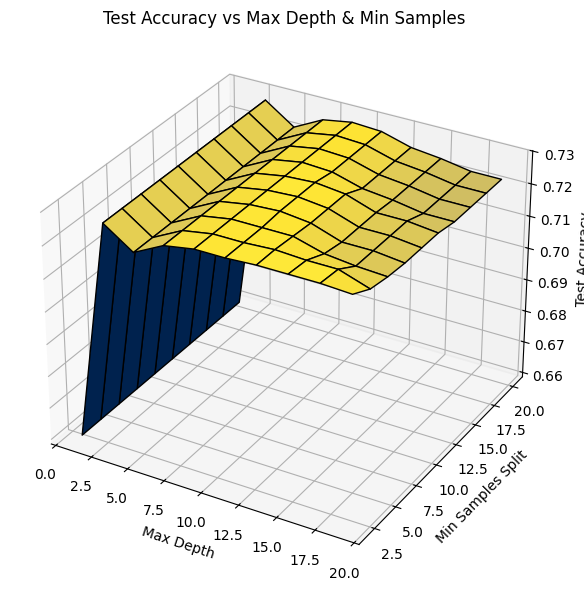

In [ ]:
fig2 = plt.figure(figsize=(6, 6))
ax2 = fig2.add_subplot(111, projection='3d')
ax2.plot_surface(xGrid, yGrid, zTest, cmap='cividis', edgecolor='black', antialiased=True)
ax2.set_xlabel('Max Depth')
ax2.set_ylabel('Min Samples Split')
ax2.set_zlabel('Test Accuracy')
ax2.set_title('Test Accuracy vs Max Depth & Min Samples')
plt.tight_layout()
plt.show()

### (c) Test and Training Accuracy
As shown from the 3D plots above, the accuracy reaches 73-75% from the training and test samples. For the test data, the accuracy is the highest when the maximum depth is around 5. Increasing the max depth or having a max depth that is too low leads to a decrease in accuracy. Also, when the max depth is higher, the model's accuracy will fluctuate with increases in minimum samples split. For the training data, the accuracy is more consistent across changes in hyperparameters, while for the test data, a lower depth, but not too low, is preferred. When the minimum samples split is too large, it also harms the accuracy.

### (d) Computation Complexity.

Train: O(p * d * n^2)

The train function relies upon two helper functions: split, and gini_index, which are used to determine the best splits and calculate gini. For each feature, d, the train algorithm will obtain unique thresholds O(n) times, one for each sample in the training size. And the gini_index function is used on the resulting subset, thus also taking O(n) time. So far, the worst case time complexity is O(d * n^2). The train function itself relies heavily upon recursive calls, which build the left and right subtrees until a maximum depth of p is reached, therefore the overall computation complexity of the train function is: O(p * d * n^2) .

Predict: O(n * p)

The predict function has a much simpler computation complexity. The predict function uses the Node class I defined to store the feature, threshold, pointers to left and right children, and prediction. For each sample n in xTest, the algorithm starts at the root and goes down to the leaf. The path would be as long as the maximum depth, p and each individual node would be visited in O(1) time. The cost for one sample would be
O(p) since the max depth is p. And since xTest has n number of samples, the overall complexity would then be O(n * p)